In [1]:
import os
import random
from sklearn.model_selection import train_test_split
import cv2

In [2]:
path = "data/Images"

In [3]:
image_size=(128, 128)
all_data=[]
classes=os.listdir(path)
for class_name in classes:
    class_path=os.path.join(path, class_name)
    if not os.path.isdir(class_path):
        continue
    image_paths=os.listdir(class_path)
    for image_name in image_paths:
        image_path=os.path.join(class_path, image_name)
        if not image_name.lower().endswith('.jpg'):
            continue
        image=cv2.imread(image_path)
        if image is None:
            continue
        image=cv2.resize(image, image_size)
        image=image / 255.0 
        all_data.append((image, class_name))

In [4]:
print(f"Total Image Count: {len(all_data)}")

Total Image Count: 9679


In [5]:
train_ratio=0.7
test_ratio=0.15
validation_ratio=0.15
train_data=[]
validation_data=[]
test_data=[]

In [6]:
class_data={}
for img, label in all_data:
    if label not in class_data:
        class_data[label]=[]
    class_data[label].append((img, label))

In [7]:
for label, items in class_data.items():
    random.shuffle(items)
    train, temp=train_test_split(items, test_size=(validation_ratio + test_ratio))
    val, test=train_test_split(temp, test_size=(test_ratio / (validation_ratio + test_ratio)))
    train_data.extend(train)
    validation_data.extend(val)
    test_data.extend(test)

In [8]:
import numpy as np
def prepare_data(data_list):
    x=np.array([item[0] for item in data_list])
    y=np.array([classes.index(item[1]) for item in data_list])
    return x,y

In [9]:
x_train, y_train=prepare_data(train_data)
x_val, y_val=prepare_data(validation_data)
x_test, y_test=prepare_data(test_data)

In [10]:
import warnings
warnings.filterwarnings("ignore")

In [11]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [12]:
base_model=VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

In [13]:
def only_fc_layers():
    for layer in base_model.layers:
        layer.trainable=False
    model=Sequential([
        base_model,
        #Flatten(input_shape=(128, 128, 3)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(len(classes), activation='softmax')]
    )
    return model

In [14]:
def last_two_convolutional_layers():
    for layer in base_model.layers[:-4]:
        layer.trainable = False
    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(len(classes), activation='softmax')]
    )
    return model

In [24]:
def train_model(model, x_train, y_train, x_val, y_val, learning_rate, batch_size, epochs=15):
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        batch_size=batch_size,
        epochs=epochs,
        verbose=1
    )
    return model, history

In [16]:
def plot_confusion_matrix(model, x_test, y_test):
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    cm=confusion_matrix(y_test, y_pred_classes)
    disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    fig, ax=plt.subplots(figsize=(20, 20))
    disp.plot(cmap='viridis', ax=ax, xticks_rotation='vertical')
    plt.show()


In [ ]:
#first model

In [25]:
first_model=only_fc_layers()


In [26]:
first_model, first_history=train_model(first_model, x_train, y_train, x_val, y_val,learning_rate=0.0005, batch_size=32)

Epoch 1/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 205s 961ms/step - accuracy: 0.2057 - loss: 2.7470 - val_accuracy: 0.4955 - val_loss: 1.7806
Epoch 2/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 196s 926ms/step - accuracy: 0.4462 - loss: 1.8306 - val_accuracy: 0.5471 - val_loss: 1.5206
Epoch 3/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 198s 932ms/step - accuracy: 0.5282 - loss: 1.5354 - val_accuracy: 0.5747 - val_loss: 1.4338
Epoch 4/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 196s 925ms/step - accuracy: 0.5819 - loss: 1.3512 - val_accuracy: 0.5953 - val_loss: 1.3298
Epoch 5/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 198s 937ms/step - accuracy: 0.6357 - loss: 1.1520 - val_accuracy: 0.6167 - val_loss: 1.2619
Epoch 6/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 203s 956ms/step - accuracy: 0.6724 - loss: 1.0482 - val_accuracy: 0.6111 - val_loss: 1.2726
Epoch 7/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 196s 927ms/step - accuracy: 0.6984 - loss: 0.9531 - val_accuracy: 0.6215 - val_loss: 1.2241
Epoch 8/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 196s 926ms/step - accuracy: 0.7306 -

In [27]:
first_test_loss, first_test_accuracy=first_model.evaluate(x_test, y_test)

46/46 ━━━━━━━━━━━━━━━━━━━━ 31s 680ms/step - accuracy: 0.6351 - loss: 1.2011


In [28]:
print(f"First Model -> Test Accuracy: {first_test_accuracy}, Test Loss: {first_test_loss}")

First Model -> Test Accuracy: 0.6180698275566101, Test Loss: 1.2979955673217773


46/46 ━━━━━━━━━━━━━━━━━━━━ 34s 742ms/step


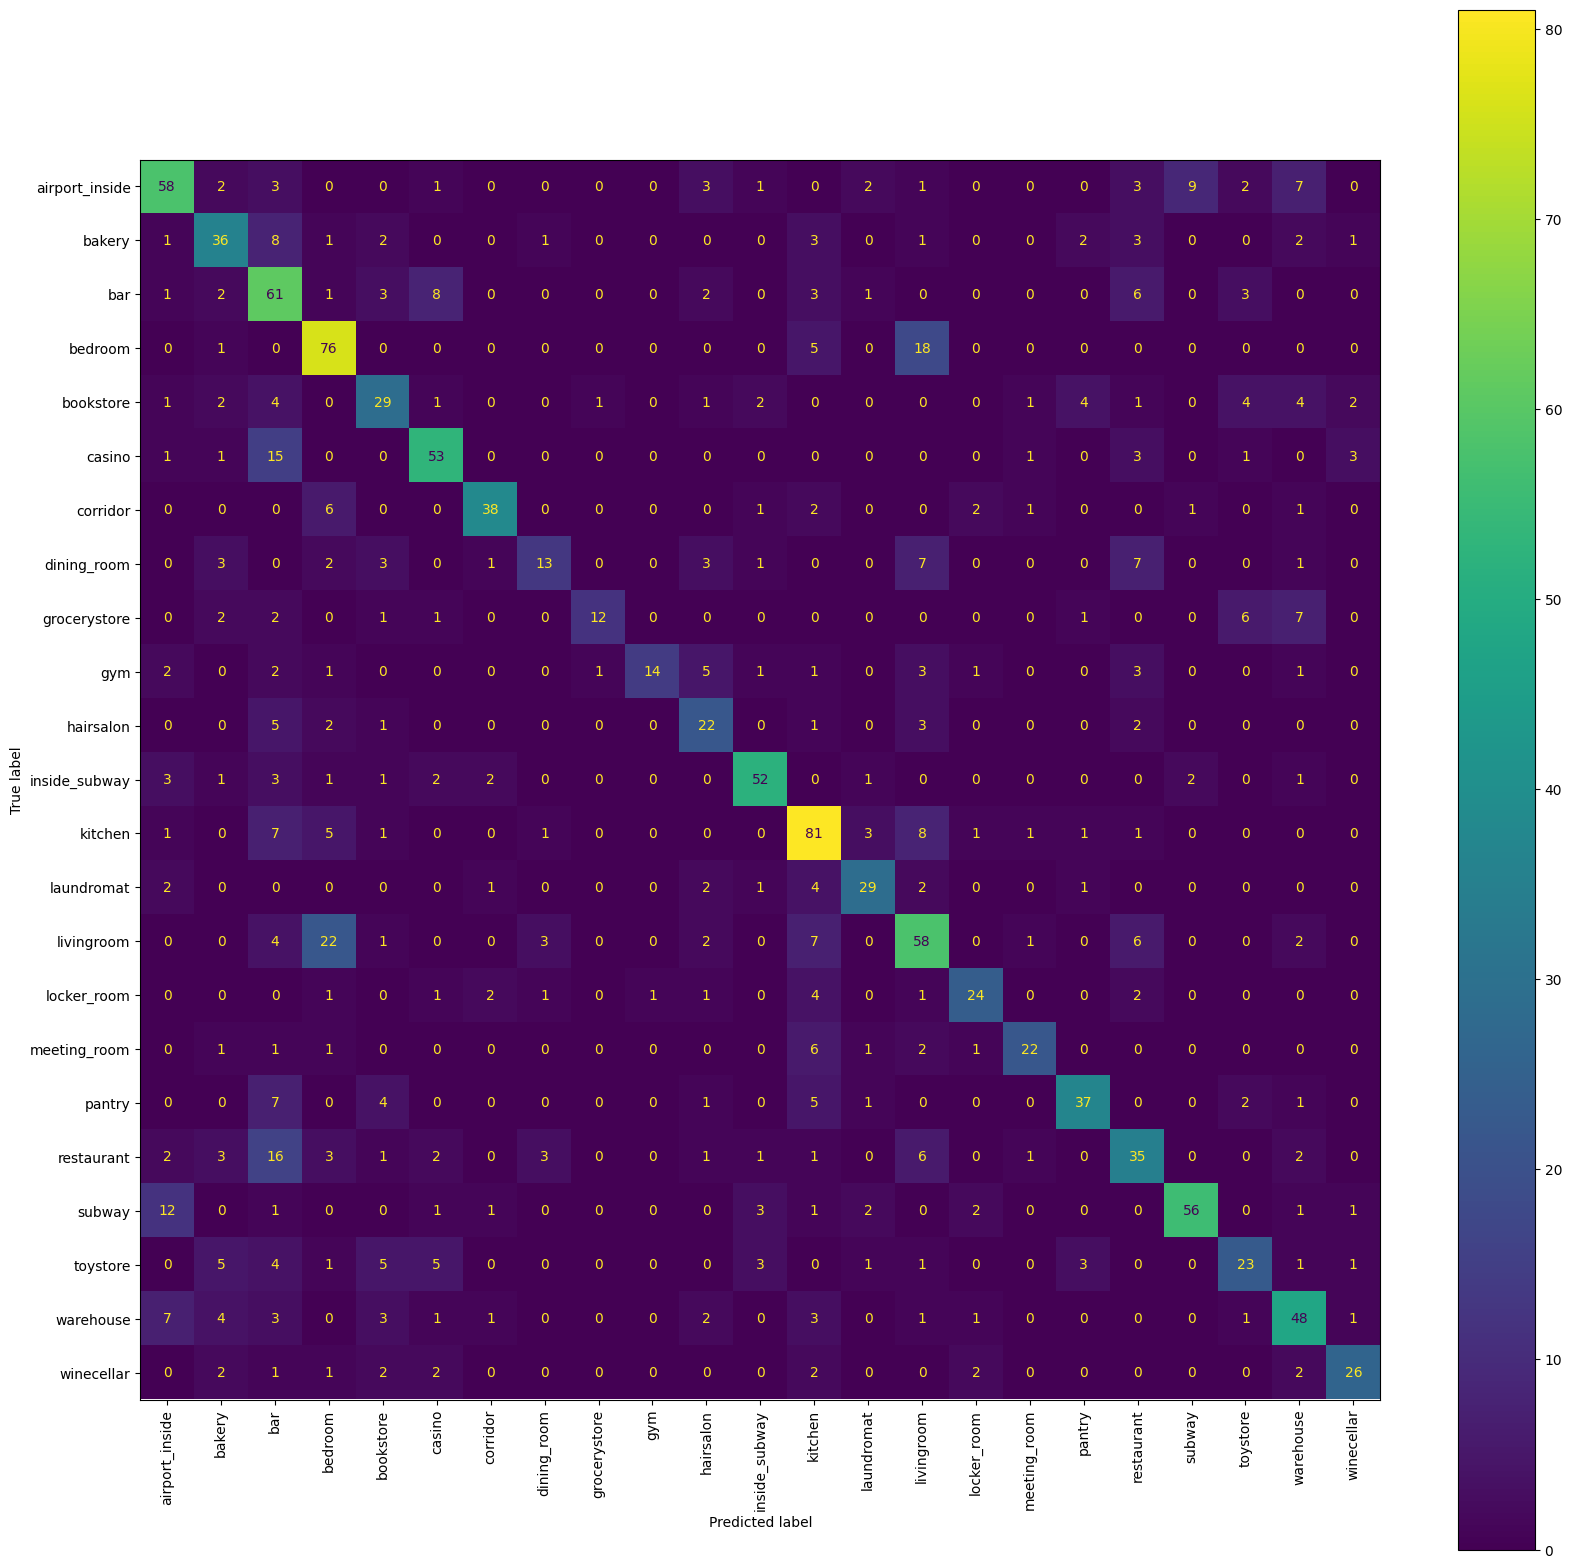

In [29]:
plot_confusion_matrix(first_model, x_test, y_test)

In [ ]:
##second model

In [30]:
second_model=last_two_convolutional_layers()

In [31]:
second_model, second_history = train_model(second_model, x_train, y_train, x_val, y_val, learning_rate=0.0005, batch_size=32)

Epoch 1/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 190s 893ms/step - accuracy: 0.1984 - loss: 2.7625 - val_accuracy: 0.4529 - val_loss: 1.8373
Epoch 2/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 196s 923ms/step - accuracy: 0.4143 - loss: 1.9066 - val_accuracy: 0.5313 - val_loss: 1.6077
Epoch 3/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 195s 921ms/step - accuracy: 0.5195 - loss: 1.5876 - val_accuracy: 0.5953 - val_loss: 1.4077
Epoch 4/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 195s 922ms/step - accuracy: 0.5865 - loss: 1.3694 - val_accuracy: 0.5946 - val_loss: 1.3685
Epoch 5/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 196s 924ms/step - accuracy: 0.6097 - loss: 1.2450 - val_accuracy: 0.6098 - val_loss: 1.2939
Epoch 6/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 195s 922ms/step - accuracy: 0.6391 - loss: 1.1326 - val_accuracy: 0.6132 - val_loss: 1.2748
Epoch 7/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 197s 928ms/step - accuracy: 0.6803 - loss: 1.0045 - val_accuracy: 0.6091 - val_loss: 1.2639
Epoch 8/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 196s 923ms/step - accuracy: 0.7141 -

In [34]:
second_test_loss, second_test_accuracy=second_model.evaluate(x_test, y_test)

46/46 ━━━━━━━━━━━━━━━━━━━━ 33s 714ms/step - accuracy: 0.5992 - loss: 1.2686


In [35]:
print(f"Second Model -> Test Accuracy: {second_test_accuracy}, Test Loss: {second_test_loss}")

Second Model -> Test Accuracy: 0.6160164475440979, Test Loss: 1.2477840185165405


46/46 ━━━━━━━━━━━━━━━━━━━━ 36s 780ms/step


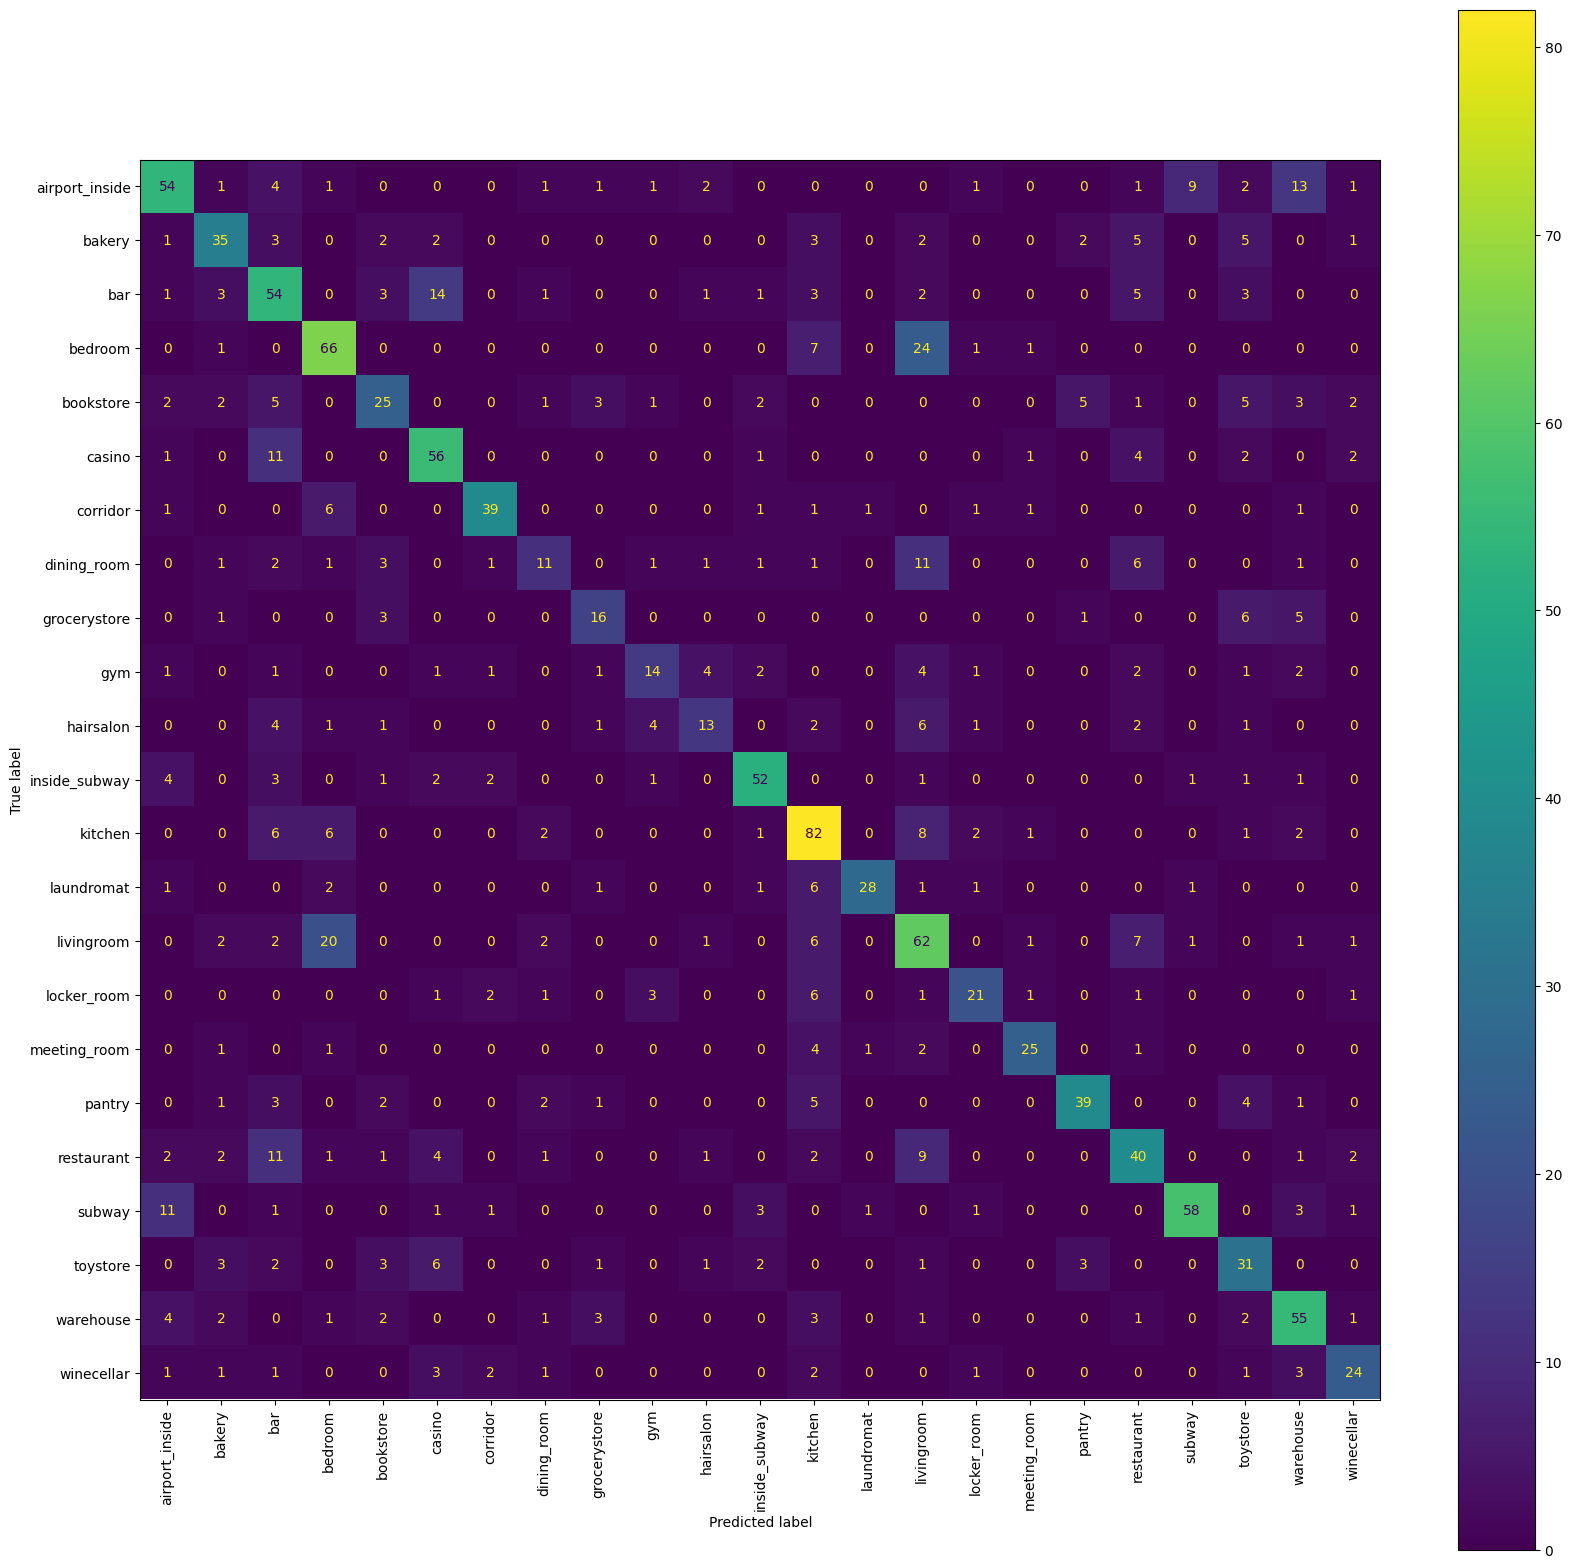

In [36]:
plot_confusion_matrix(second_model, x_test, y_test)

In part2, we are asked to use pretrained vgg16 base model. We had to use the model in two different fine-tuning scenarios. Then, we had to train and test the models with the same data in part 1 and observe the results.
Fine tuning is optimizing weights of a pretrained model to adapt it to a new dataset. In this part, we did this processes:
1) Freezing Layers: The weights of the lower convolutional layers were frozen, allowing only the Fully Connected (FC) layers to be optimized. This preserves the feature extraction capabilities of the pre-trained model.
2) Modifying the Output Layer: The output layer was redefined to match the number of classes in the dataset, and its weights were randomly initialized.
3) Using FC Layers Only or Using Last Two Convolutional Layers + FC Layers: In Using FC only case, all convolutional layers were frozen, and only the FC layers were optimized. In Using Last Two Convolutional Layers + FC Layers case, the last two convolutional layers, along with the FC layers, were optimized.
used epochs as 15, batch_number as 32 and learning rate as 0.0005. I wanted to use higher epochs, but because of high running time and some computer issues, I could not increase epoch number. I also chose batch number and learning rate from part1's best results parameters.

Results with Only FC Layers:
Maximum training accuracy: 86.82%
Maximum validation accuracy: 62.56%
Signs of overfitting were observed towards the final epochs as validation loss increased.
Test accuracy: 61.81%
Test loss: 1.30

Results with Last Two Convolutional Layers + FC Layers:
Maximum training accuracy: 85.07%
Maximum validation accuracy: 63.66%
Validation loss was slightly lower compared to the first model, generated better generalization.
Test accuracy: 61.60%
Test loss: 1.25

Test accuracies are very close, but validation accuracy is slightly better. This may be show that more layers increase model's generalization ability. Also, second model's test loss is slightly less than the first one, so it may be show that second model is more stable.

Comparison with Part1:
In part1, the best test accuracy was 0.34. The lowest test loss was 2.24. So it shows that using transfer learning has huge positive effect on learning. Also test loss is much lower in transfer learning cases. However, even it was not a big problem like in the part1, overfitting is still there. I expected that the transfer learning models could have generalized better.

I used the same data in part1. As in part1, using more data, data augmentation, using more optimal parameters may increase the success of models. 